# COGS 108 - Final Project 

# Overview

In this project, I took the provided datasets in addition to one external json file to conduct an in-depth analysis to answer a question about health inspection scores in the state of North Carolina. I first cleaned the data by making a few methods and merging the different datasets into one, from there I conducted analysis through plots and tables. After the analysis, the results depicted that there is a slight relationship between inspection scores and median houshold incomes, but when the type of cuisine is taken into account, the relationship is stronger.

# Name & GitHub

- Name: Juan Leon
- GitHub Username: jp1301

# Research Question

Is there a relationship between better health inspection scores and restaurants in affluent neighborhoods versus less affluent neighborhoods across the state of North Carolina?

## Background and Prior Work

Health inspections are conducted nationwide as a way to reduce risks associted with food safety and sanitaion. These inspections are conducted by specific individuals who visit the site of the restaurant or local being inspected and conduct a "routine" type of inspection. These routine type inspections are classified as "unannounced periodic inspection conducted as a part of an ongoing regulatory scheme based on the establisment's risk category." **[1]** Moreover, if the restaurant or local that has gone through a routine inspection had "items that were not in compliance at the time of the routine inspection," a follow-up inspection is then conducted. This follow-up is also unannounced and has no specific set time. Asside from these, there is a complaint type of inspection, which is brought upon a restaurant as a result of a public complaint to the health department. After inspections are conducted, scores are given to these restaurants that is a representative of that restaurants cleanliness. 
In the research paper by Andrew Choothakan of the University of Sanfrancisco titled "Examining Restaurant Sanitation Scores Across Cuisines" the researcher explores a similar question to the one I posed. This researcher collected data from the San Francisco Department of Public Health (SFDPH) to "investigate possible correlations such as location and price of the restaurants in relation to health score."**[2]** Through their analysis of health score data in the San Francisco area of Asian restaurants the researcher was able to find a correlation between impoverished neighborhoods and a tendency for lower health inspection score. Though this researcher put an emphasis on Asian cuisine over others, this correlation of economic power and health inspection scores could potentially be useful to find similar patterns amongst other types of locals.

References (include links):
- 1)https://dchealth.dc.gov/service/understanding-food-establishment-inspections
- 2)https://repository.usfca.edu/cgi/viewcontent.cgi?article=1195&context=capstone

# Hypothesis


After taking a closer look at the results from the backround research, there seems to be a potential for a reciprocal relationship between health inspection scores and affluent neighborhods. By this I mean that a higher health isnpection score is to be expected from an affluent neighborhood than from that of an impoverished one and vice-versa.

# Dataset(s)

- **Dataset Name**: NC-37-north-carolina-counties.json
- Link to the dataset: https://github.com/deldersveld/topojson/blob/master/countries/us-states/NC-37-north-carolina-counties.json
- Number of observations: Map
- This dataset was used to create the visualization of the map included in the analysis section of this project. 
- **Dataset name**: Inspections
- Link to the dataset: inspections.csv
- Number of observations: 18466
- This dataset contains information about health inspections done on multiple food servers across the state of North Carolina.
- **Dataset name**: Yelp
- Link to the dataset: yelp.csv
- Number of observations: 3688
- This dataset contains information about yelp reviews of different restaurants from specific zip codes of the state of North Carolina.
- **Dataset name**: Restaurants
- Link to the dataset: restaurant.csv
- Number of observations: 3324
- This dataset includes information regarding food services across the state of North Carolina.
- **Dataset name**: Zip codes
- Link to the dataset: restaurants.csv
- Number of observations:38
- This dataset contains the information of about the different zip codes of the state of North Carolina.
- I plan to combine the ‘Inspections’, ‘Yelp’, ‘Restaurants’, and ‘Zip codes’ datasets by merging them into a singular dataset from which I will make my analysis. I plan for the final dataset to contain elements present in each of the individual datasets.


# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import json
import folium
from folium import plugins
import patsy
import statsmodels.api as sm
import seaborn as sns
sns.set()
sns.set_context('talk')
import statistics
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [2]:
df_vio = pd.read_csv('violations.csv')
df_insp = pd.read_csv('inspections.csv')
df_yelp = pd.read_csv('yelp.csv')
df_rest = pd.read_csv('restaurants.csv')
df_zip = pd.read_csv('zipcodes.csv')

I first decided to make a copy of the dataset named df_zip, from that copy, I decided to drop the columns that would not be useful for my final dataset and rename the rest of them. I then repeated this process for the datasets named df_rest , df_insp, and df_yelp. 

In [3]:
df_zip2 = df_zip

In [4]:
df_zip2 = df_zip2.drop(['median_family_income_dollars','per_capita_income_dollars','percent_snap_benefits','percent_supplemental_security_income'], axis = 1)

In [5]:
df_yelp2 = df_yelp

In [6]:
df_yelp2 = df_yelp.drop (['id','hotdogs','sandwiches','pizza','breakfast_brunch','chicken_wings','seafood','bbq','is_closed','rating','phone','tradamerican','coffee','newamerican','grocery','delis','bars','bakeries','salad','review_count','price', 'latitude','longitude'], axis = 1)

In [7]:
df_yelp2.columns = ['name','address','zip','burgers','mexican','chinese','italian','sushi']

In [8]:
df_rest2 = df_rest.drop(['X.objectid','address2','postalcode','phonenumber','restaurantopendate', 'facilitytype'], axis = 1)

In [9]:
df_zip2.columns = ['zip', 'med_household_income', 'families_below_poverty_line(%)', 'nonwhite(%)']

In [10]:
df_insp2 = df_insp.drop (['previous_inspection_date','address2', 'phonenumber', 'restaurantopendate', 'days_from_open_date', 'inspectedby', 'num_critical_previous','num_non_critical_previous','num_critical_mean_previous','num_non_critical_mean_previous', 'avg_neighbor_num_critical',
       'avg_neighbor_num_non_critical', 'top_match', 'second_match','critical', 'description', 'postalcode', 'type'], axis = 1)

Here, I made a new data frame which consisted of a merge between df_insp2 and df_rest2, I merged it on the column name ‘hsisid’. Then in that new merged data frame, I decided to drop all the observations that were not considered restaurants under the column ‘facilitytype’ because my question is only concerned with the restaurants in North Carolina not all food servers. I then dropped the duplicated columns that were left after the merger, after which I sorted the values of that data frame by the columns ‘hsisid’ and ‘inspection_num’. After the sorting, I dropped the observations that had duplicates in the ‘hsisid’. I did this to only keep the most recent inspection done to each of the restaurants. Then I dropped a couple columns and renamed the rest. 

In [11]:
df_new = df_insp2.merge(df_rest2, on = 'hsisid')

In [12]:
df = df_new[df_new['facilitytype'] == 'Restaurant']

In [13]:
df = df.drop (['name_y', 'address1_y', 'city_y','state_y','x_x','y_x','geocodestatus_x'], axis =1)

In [14]:
df2 = df.sort_values(by = ['hsisid', 'inspection_num'])

In [15]:
df2 = df2.drop_duplicates(subset=['hsisid'], keep='last')

In [16]:
df2 = df2.drop (['previous_inspection_by_same_inspector', 'facilitytype','geocodestatus_y'], axis = 1)

Here, I made a new method called date to standardize the column ‘date’, then I applied it to the data frame and I renamed the columns in df2.

In [17]:
def date(string):
    string = str(string)
    string = string.lower()
    string = string.strip()
    string = str(string)
    if '2015' in string:
        out = '2015'
    elif '2016' in string:
        out = '2016'
    elif '2014' in string:
        out = '2014'
    elif '2013' in string:
        out = '2013'
    else:
        out = str(string)
    return out

In [18]:
df2['date'] = df['date'].apply(date)

In [19]:
df2.columns=['hsisid','date','name','address', 'city', 'state', 'zip',
       'inspection_num', 'inspector_id', 'days_since_previous_inspection',
       'score', 'num_critical', 'num_non_critical', 'longitude', 'latitude']

I then made another method name low to standardize the names of the restaurants in the merged data frame and the yelp data frame. 

In [20]:
def low(string):
    string = str(string)
    string = string.lower()
    string = string.strip()
    return string

In [21]:
df2['name'] = df2['name'].apply(low)

In [22]:
df_yelp2['name'] = df_yelp2['name'].apply(low)

Here I noticed that the yelp data frame had columns in which the type of cuisine of each restaurant was valued by Booleans. I wanted to see if ethnic foods would be a confound to my hypothesis so I decided to drop all the columns that did not seem to be explicitly ‘ethnic’ (i.e. ‘mexican’). I kept only 1 explicitly ‘nonethnic’  column ‘burgers’ as a control.

In [23]:
nonethnic = df_yelp2[(df_yelp2['mexican']== False)&(df_yelp2['burgers']==False)&(df_yelp2['chinese']==False)&(df_yelp2['italian']== False)&(df_yelp2['sushi']== False)].index
df_yelp2.drop(nonethnic, inplace =True)

Here I dropped the duplicate observations, then I merged the yelp data frame with the previously merged (inspection and restaurant) data frame into a df3 by the column ‘name’ that had been standardized earlier. Then I dropped duplicated columns and any other column that I did not think would be useful for the purpose of my analysis.

In [24]:
df_yelp2= df_yelp2.drop_duplicates()

In [25]:
df3 = pd.merge(df2, df_yelp2, on = 'name')

In [26]:
df3 = df3.drop (['address_x', 'address_y','days_since_previous_inspection', 'zip_y'], axis = 1)

Here, into a new data frame df4, I dropped duplicate observations by the column ‘hsisid’. Then I renamed the columns and reset the indexes.

In [27]:
df4= df3.drop_duplicates(subset=['hsisid'], keep='last')

In [28]:
df4.columns=['hsisid','date','name','city','state','zip','inspection_num','inspector_id','score','num_critical','num_non_critical','longitude','latitude','burgers','mexican','chinese','italian','sushi']

In [29]:
df4.reset_index(drop=True)

,hsisid,date,name,city,state,zip,inspection_num,inspector_id,score,num_critical,num_non_critical,longitude,latitude,burgers,mexican,chinese,italian,sushi
0,4092010138,2015,char-grill,raleigh,NC,27612,5,25.0,94.0,4,10,-78.705805,35.825553,True,False,False,False,False
1,4092011062,2016,char-grill,raleigh,NC,27604,6,21.0,98.5,1,0,-78.602929,35.848019,True,False,False,False,False
2,4092011976,2016,char-grill,raleigh,NC,27615,4,29.0,95.5,0,6,-78.655831,35.901147,True,False,False,False,False
3,4092010154,2016,china star,raleigh,NC,27612,11,19.0,93.0,5,10,-78.705568,35.825451,False,False,True,False,False
4,4092017141,2016,china star,raleigh,NC,27610,2,5.0,98.0,1,5,-78.549471,35.725619,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,4092017197,2016,el taco market,raleigh,NC,27610,2,28.0,97.5,2,4,-78.576002,35.797435,False,True,False,False,False
198,4092017206,2016,tijuana flats,cary,NC,27513,1,1.0,92.5,6,11,-78.845584,35.793256,False,True,False,False,False
199,4092017245,2016,salvio's pizzeria,raleigh,NC,27615,1,15.0,98.0,1,5,-78.622516,35.869229,False,False,False,True,False
200,4092017301,2016,esmeralda grill,cary,NC,27511,1,22.0,93.5,6,2,-78.765142,35.791572,False,True,False,False,False


Here I made a few methods to change the Boolean valued columns into string columns. I applied these methods to specific columns of the data frame. Then I made a new column in which the information about the types of cuisine would be compiled.

In [30]:
def ethnic1(boolean):
    if boolean != False:
        out = 'mexican'
    else:
        out = ''
    return out

In [31]:
def ethnic2(boolean):
    if boolean != False:
        out = 'asian'
    else:
        out = ''
    return out

In [32]:
def ethnic3(boolean): 
    if boolean != False:
        out = 'italian'
    else:
        out = ''
    return out
        

In [33]:
def ethnic4(boolean): 
    if boolean != False:
        out = 'burgers'
    else:
        out = ''
    return out
        

In [34]:
df4['mexican'] = df4['mexican'].apply(ethnic1)
df4['chinese'] = df4['chinese'].apply(ethnic2)
df4['italian'] = df4['italian'].apply(ethnic3)
df4['sushi'] = df4['sushi'].apply(ethnic2)
df4['burgers'] = df4['burgers'].apply(ethnic4)

In [35]:
df4['type'] = df4['mexican']+df4['chinese']+df4['italian']+df4['sushi']+df4['burgers']

Here I standardized the new column ‘type’ to include only ‘1’ or ‘2’ depending on whether each observation was ‘ethnic’ or ‘nonethnic’.  Then I dropped the columns used to make the new column since the information was no longer necessary.

In [36]:
def clean(string):
    string = string.lower()
    string = string.strip()
    if 'burgers' in string:
        out = '2'
    elif 'mexican' in string:
        out = '1'
    elif 'asian' in string:
        out = '1'
    elif 'italian' in string:
        out = '1'
    else:
        out = string
    return out

In [37]:
df4['type'] = df4['type'].apply(clean)

In [38]:
df4 = df4.drop (['mexican','chinese','italian','sushi', 'burgers'], axis = 1)

Here I made a new data frame which merged the copy ‘zip’ data frame(df_zip2) and df2 by the ‘zip’ column, I named the new merged data frame df_comp, then I merged df_comp with df4 by the column ‘zip’. I named the merged data frame ‘df_fin’ which I then dropped the duplicated observations and the duplicated columns. Then I renamed the columns.

In [39]:
df_comp = df_zip2.merge(df2, on = 'zip')

In [40]:
df_fin = df_comp.merge(df4, on = 'zip')

In [41]:
df_fin= df_fin.drop_duplicates(subset=['hsisid_x'], keep='first')

In [42]:
df_fin = df_fin.drop (['hsisid_y','name_x','name_y','longitude_y', 'num_critical_x', 'num_non_critical_y','days_since_previous_inspection','inspector_id_y','address','date_y','city_y','state_y','inspection_num_x','inspector_id_x','score_y','num_critical_y','num_non_critical_x','latitude_y'], axis = 1)

In [43]:
df_fin.columns = ['zip','med_household_income', 'families_below_poverty_line(%)',
       'nonwhite(%)', 'hsisid', 'date', 'city',
       'state', 'score','longitude','latitude', 'inspection_num', 'type']

Here I took the log base 10 of the ‘med_household_income’ column and made a new column named ‘income10’ to make some of the visualizations easier to read. After this my final dataset was complete.

In [44]:
df_fin['income10'] = np.log10(df_fin['med_household_income'])

# Data Analysis & Results

Here I plotted the distribution of the median household income as a histogram and in it I included the mean and median.

Text(0.5, 1.0, 'Distribution of Median Household Income')

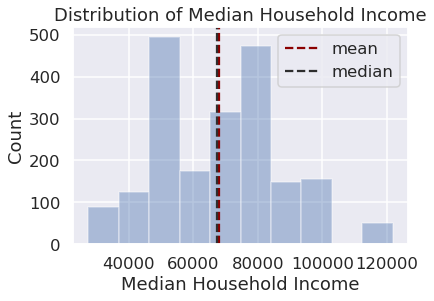

In [45]:
ax = sns.distplot(df_fin['med_household_income'], kde = False, bins = 10);
ax.axvline(df_fin['med_household_income'].mean(), color = 'darkred', linestyle = '--',label = 'mean');
ax.axvline(df_fin['med_household_income'].median(), color='#2e2e2e', linestyle='--', label='median')
ax.legend();
plt.xlabel('Median Household Income')
plt.ylabel('Count')
plt.title('Distribution of Median Household Income')

Here I plotted the distribution of the scores as a histogram as well and I also included the mean and median

Text(0.5, 1.0, 'Distribution of Scores')

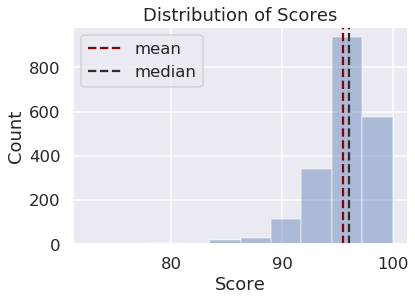

In [46]:
ax = sns.distplot(df_fin['score'], kde = False, bins = 10);
ax.axvline(df_fin['score'].mean(), color = 'darkred', linestyle = '--',label = 'mean');
ax.axvline(df_fin['score'].median(), color='#2e2e2e', linestyle='--', label='median')
ax.legend();
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')

Here I plotted the relationship between income and scored and separated the plots into the two types, ‘1’(ethnic restaurants), and ‘2’(nonethnic restaurants). This plot showed that there is a negative correlation between income and score for type 1, but a positive correlation between income and score fore type 2.

Text(0.5, 0.98, 'Relationship Between Income and Score Diserned by Type')

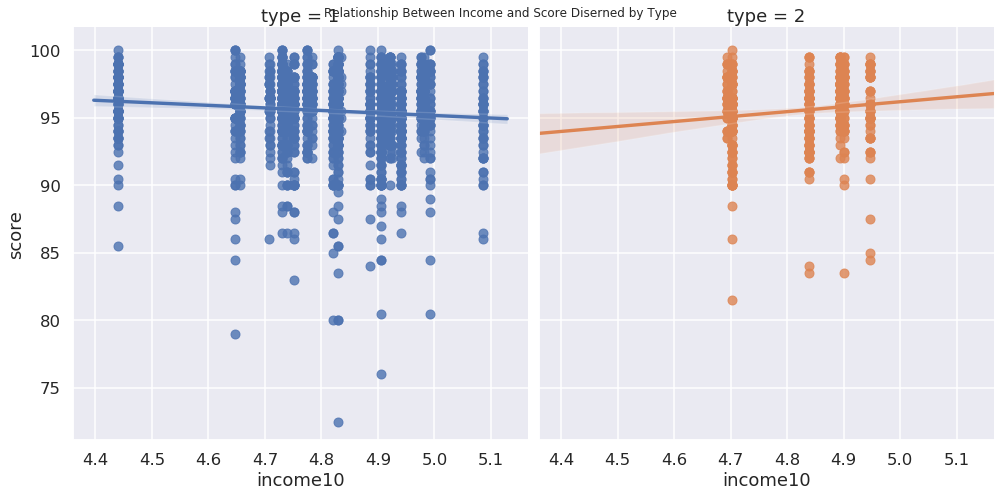

In [47]:
lm = sns.lmplot(x= 'income10', y= 'score',col ='type', hue = 'type', height=7,data= df_fin)
fig= lm.fig
fig.suptitle('Relationship Between Income and Score Diserned by Type', fontsize = 12)


To explore the results from the last figure, I did a ordinary least square regression, I had the ‘score’ be the outcome and the ‘med_household_income’ be the predictor. The results demonstrated a low p-value which indicates that there is a relationship between score and med_household_income when you take into account type of cuisine as well.

In [48]:
outcome_1, predictors_1 = patsy.dmatrices('score ~ income10 + type',df_fin)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [49]:
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.576
Date:                Wed, 10 Jun 2020   Prob (F-statistic):             0.0282
Time:                        17:49:33   Log-Likelihood:                -5038.3
No. Observations:                2026   AIC:                         1.008e+04
Df Residuals:                    2023   BIC:                         1.010e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.8269      2.364     43.078      0.0

Here I made a boxplot to see if there was a difference in med_household_income depending on the type of food served (ethnic vs nonethnic). The results demonstrated that income varies more for the restaurants whose typing is 1(ethnic) when compared to type 2. The type 1 restaurants also have a lower median.

Text(0.5, 1.0, 'Median Household Income Distribution by Type')

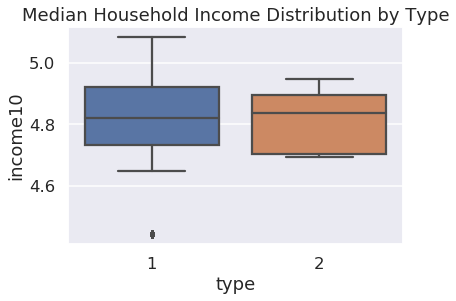

In [50]:
st = sns.boxplot(x='type', y= 'income10', data = df_fin)
st.set_title('Median Household Income Distribution by Type')

Here I did a made a few pivot tables to explore the relationships between certain variables more. First, I compared ‘score’ and ‘type’, this showed that type 2 have a slightly higher mean score than type 1. 

In [51]:
pv = pd.pivot_table(df_fin, values = 'score', index = ['type'])
pv

,score
type,
1,95.525202
2,95.556086


Next, I compared ‘med_household_income’ and ‘type’, this showed that type 2 have a higher mean income when compared to type 1. 

In [52]:
pv2 = pd.pivot_table(df_fin, values = 'med_household_income', index = ['type'])
pv2

,med_household_income
type,
1,67790.697573
2,68804.343675


Then, I compared ‘percentage of families below poverty line’ with ‘type’ and this result showed a higher mean percentage of families under the line of poverty for restaurants that were considered type 1 than those of type 2. 

In [53]:
pv3 = pd.pivot_table(df_fin, values = 'families_below_poverty_line(%)', index = ['type'])
pv3

,families_below_poverty_line(%)
type,
1,9.727318
2,6.749642


Next, I compared ‘nonwhite(%)’ and ‘type’, this depicted a higher mean percentage of nonwhite individuals for observations labeled as type 1 than those in type 2. 

In [54]:
pv4 = pd.pivot_table(df_fin, values = 'nonwhite(%)', index = ['type'])
pv4

,nonwhite(%)
type,
1,33.3486
2,25.3642


The last pivot table I made was to see if there is any relationship between types, scores, percentage of nonwhite people and percentage of family below poverty line. The results showed that when the percentage of nonwhites is low and the score is low for type 1 observations, there is a higher mean percentage of families below poverty line. Also, when the percentage of nonwhites is high and the score is high for observations in type 2 the mean percentage of families below poverty line is high. This means that there is a higher percentage of families below poverty line in areas with a higher percentage of nonwhites.

In [55]:
ye = pd.cut(df_fin['score'],[0,75,100])
wh = pd.cut(df_fin['nonwhite(%)'],[0,25,100])
df_fin.pivot_table('families_below_poverty_line(%)', ['type',ye], wh)

nonwhite(%)      (0, 25]  (25, 100]
type score                         
1    (0, 75]    9.600000        NaN
     (75, 100]  7.561920  11.107034
2    (75, 100]  4.445031  14.400000

Here I plotted a 3d subplot with Zip codes as the y axis, med_houshold_income as the x axis and score as the z axis. This plot demonstrated that even though there does not seem to be much of a connection between score and either of the other axes, there is a clear clustering of zip codes which have a lower income, which shows that certain zip codes are associated with lower income.

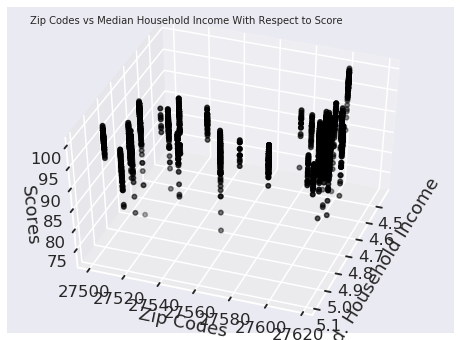

In [56]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection= '3d')
xs = df_fin['income10']
ys = df_fin['zip']
zs = df_fin['score']
ax.scatter(xs,ys,zs, s = 20, color = 'black')
ax.set_xlabel('Med. Household Income')
ax.set_ylabel('Zip Codes')
ax.set_zlabel('Scores')
ax.text2D(0.05, 0.95, "Zip Codes vs Median Household Income With Respect to Score", transform=ax.transAxes)
ax.view_init(45,20)

To explore this further, I decided to look at a map of North Carolina using folium in which I iterated through the data frame df_fin and plotted observations by their latitude and longitude in whose ‘med_household_income’ was either lower than 40,000 (lower middle class to poor colored red) or higher than 100,000 (high class or affluent colored blue). I also made it possible to hover over each observation to see the inspection scores they received. The map shows two separate clusters, one of those deemed to be of lower median household income and the other being the high median household income, with this we were able to understand where restaurants of high end were located we also determined that this map does not help in understanding the relationship between scores and relative affluency of the neighborhood. However, it does provide us with an insight of the association between certain zip codes and median household income.

In [57]:
with open ('NC-37-north-carolina-counties.json')as f:
    nc = json.load(f)

## Map of North Carolina  with  Observations Plotted

In [58]:
map = folium.Map(location = [35.85,-78.55],zoom_start =10)
for each in df_fin.iterrows():
    if each[1]['med_household_income']<40000:
        folium.Marker(
            location = [each[1]['latitude'],each[1]['longitude']],radius = 5, tooltip = each[1]['score'], icon = folium.Icon(color= 'red')).add_to(map)
    elif each[1]['med_household_income']>100000:
        folium.Marker(
            location = [each[1]['latitude'],each[1]['longitude']],radius = 5, tooltip = each[1]['score']).add_to(map)
display(map)

# Ethics & Privacy

The data required to formulate the answer to this question was provided by professor Ellis from the University of California San Diego, hence I believe that this dataset is available to the public which allows for the upholding of ethics. However,the datasets provided were not originally intended to be presented in the context of my project. Therefore, to publish this project outside of the classroom setting, there would be a need to, verify with the owners or managers that they are comfortable with their data being exposed in the context of the question. Moreover,if this project were to be released for public viewing, the results of the analysis might be used generalize to other states, this could in turn harm other regions that are more impacted in terms of ethnic representation. Also the results or process in this project could be utilized for purposes other than my intented by interpreting some of the loose conections as facts. For instance, the connection between median household income and score is not strong enough to make any explicit comments, however others might interpret it otherwise. Since the data is only representative of certain counties in the state of North Carolina, the information and conclusions drawn in this project, should not be generalized to other states in the US. That being said, if someone does use this project to make inferences on other states or regions, the data would then be considered biased.

# Conclusion & Discussion

After analysing the datasets through multiple different plots and tables, there are various different results that can be drawn outside, but relating to, the main question. For instance, there is a connection between zip codes and median household income, that is that certain zip codes have lower median income than others. Another result seen is that scores and percentage of nonwhites(minorities) are connected to the percentage of families below the poverty line. There tends to be a higher mean percentage of families below poverty line when the percentage of nonwhites is high. As for the initial question, even though there is no decrease in score with regards to a decrease in median household income of restaurants there is a correlation between income and score when taking into account the type of cuisine ethinic vs non ethnic. Meaning that my hypothesis is not accurate and requires further exploration, analysis or amount of data to find a more meaningful connection. As for the limitations, one is the time constraint in which I had to complete the project, had I had more time, a more extensive analysis would have been possible. Another limitation is the fact that my knowledge in python is discrete, therefore I was not able to make some visualizations that would have helped draw clearer conclusions.